In [3]:
from nilearn import image, input_data, masking, plotting, signal
from nilearn.datasets import MNI152_FILE_PATH
from nilearn.plotting import plot_roi, plot_epi, show
import numpy as np
import matplotlib.pylab as plt
from scipy.fftpack import fft, fftfreq
from scipy.signal import detrend, resample
from scipy.stats import zscore
from utilities import files
import os.path as op
%matplotlib inline

In [4]:
path = "/home/mszul/datasets/braindyn_localizer"
participants = files.get_folders_files(path)[0]
participant = participants[0]
_id = participant.split("/")[-1]

In [6]:
mask = "masks/hocp-Occipital_Pole.nii.gz"
nifti = op.join(
    participant, 
    "func", 
    "{}_task-faces_dir-AP_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz".format(_id)
)
brain_mask = op.join(
    participant,
    "func",
    "{}_task-faces_dir-AP_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz".format(_id)
)
t1 = op.join(
    participant,
    "anat",
    "{}_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz".format(_id)
)

In [7]:
flicker = image.smooth_img(nifti, fwhm=None)
roi = image.smooth_img(mask, fwhm=None)
roi = image.resample_to_img(roi, flicker, fill_value=0, clip=True, interpolation="nearest")
mean_flicker = image.mean_img(flicker)

# OVERVIEW OF THE fMRI-FFT ANALYSIS
### Results and considerations

##### More or less based on: Gao, X., 2018 and 2020
* spatial smoothing FWHM=3mm
* removal of a linear trend
* DRASTIC UPSAMPLING
* FFT of the time series
* extracting the value of the 0.0385 Hz frequency peak Z-scored based on surrounding frequencies

* occipital pole probabilistic map (Harvard-Oxford Pobabilistic Atlas from FSL) used as an initial mask to avoid the whole brain mask

##### Harvard-Oxford Probabilistic Atlas: Mask of OCCIPITAL POLE thresholded at 15%


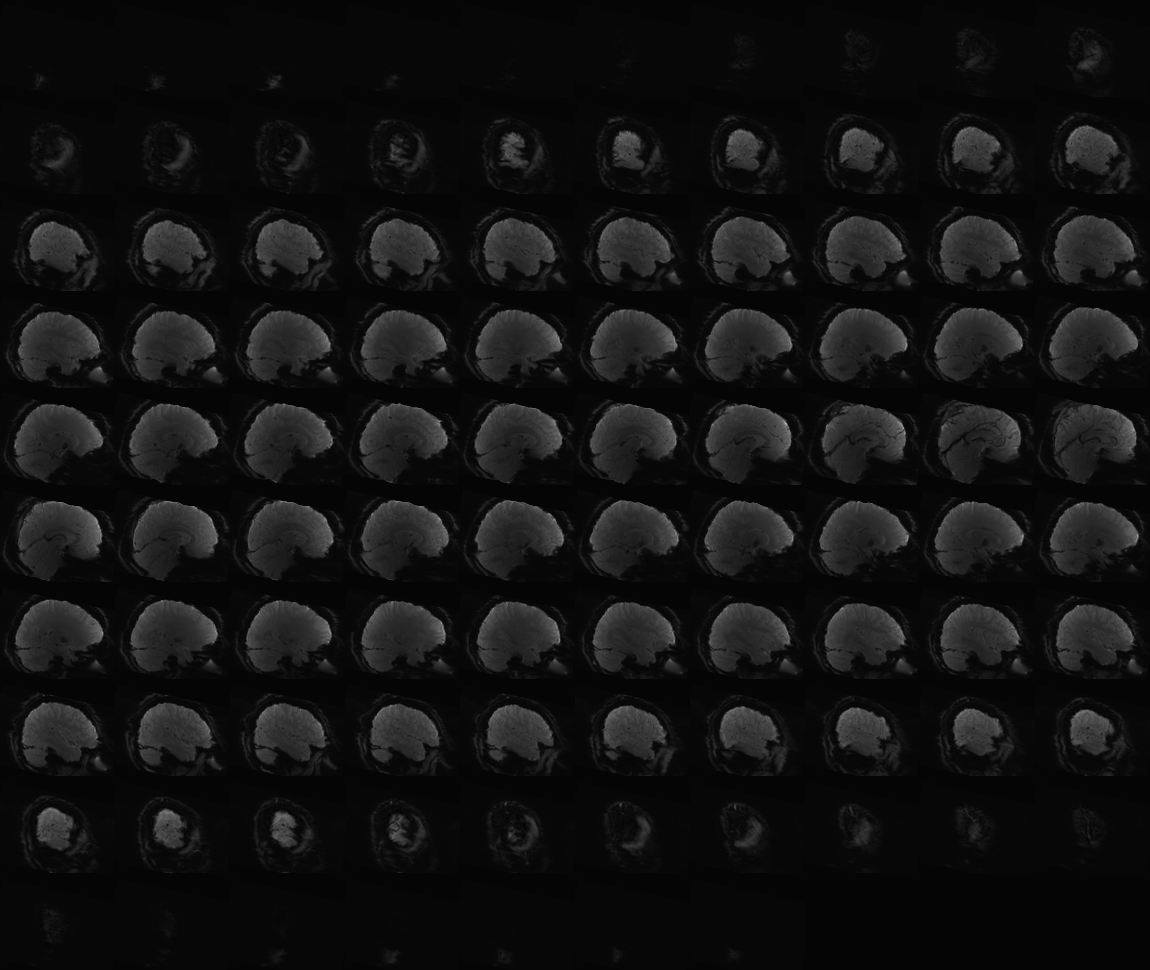
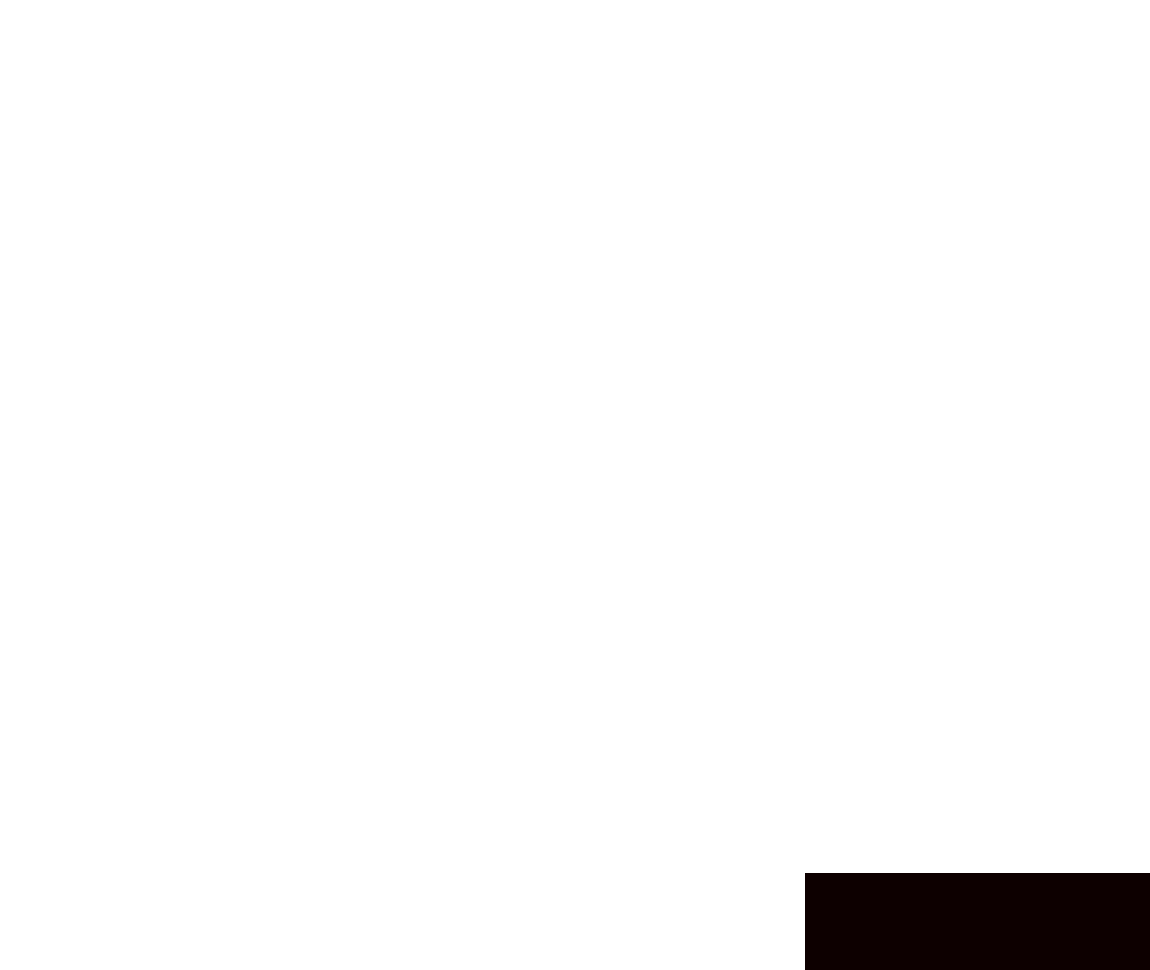

In [8]:
plotting.view_img(roi, threshold=.9999, bg_img=mean_flicker, black_bg=True)

##### Extracting the time course of the voxels from the mask (picking random 500 voxels from the mask for demonstration purposes)

In [9]:
flicker_masked = masking.apply_mask(flicker, roi, smoothing_fwhm=3)

In [10]:
voxel_sample = np.random.randint(0,flicker_masked.shape[1], 500)
voxel_sample.sort()
flicker_voxels = flicker_masked[:, voxel_sample]
del flicker_masked

In [11]:
time = np.arange(flicker_voxels.shape[0])*1.3

### RAW SIGNAL

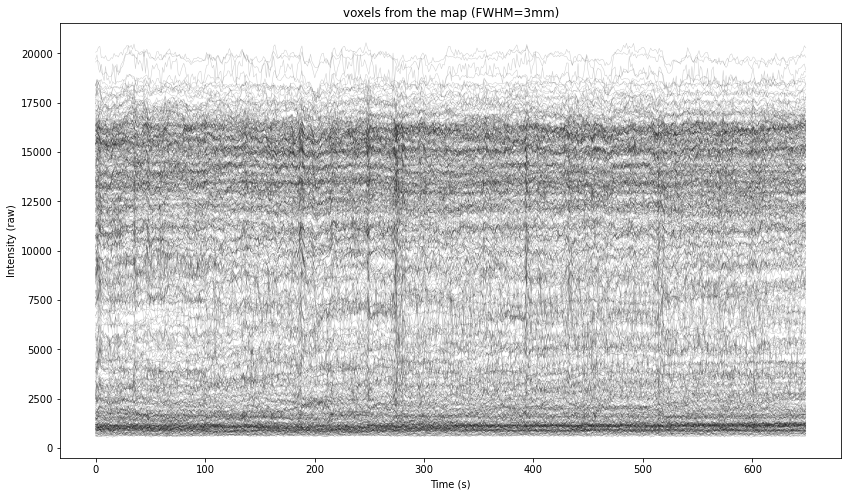

In [12]:
f, ax = plt.subplots(figsize=(14,8))
data = flicker_voxels
plt.plot(time, data, "black", alpha=0.2, lw=0.5)
plt.title("voxels from the map (FWHM=3mm)")
plt.ylabel("Intensity (raw)")
plt.xlabel("Time (s)");

### DETRENDED SIGNAL

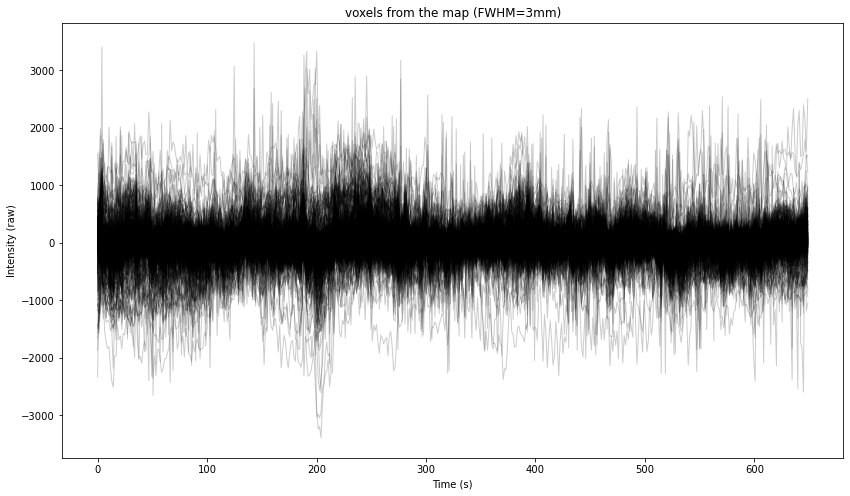

In [13]:
f, ax = plt.subplots(figsize=(14,8))
data = flicker_voxels
data = signal._detrend(data, type="linear")
plt.plot(time, data, "black", alpha=0.2, lw=1)
plt.title("voxels from the map (FWHM=3mm)")
plt.ylabel("Intensity (raw)")
plt.xlabel("Time (s)");

### DRAMATIC, DRACONIAN AND DRASTIC UPSAMPLING

##### scipy.signal.resample

Resample x to num samples using Fourier method along the given axis.

The resampled signal starts at the same value as x but is sampled with a spacing of len(x) / num * (spacing of x). Because a Fourier method is used, the signal is assumed to be periodic.




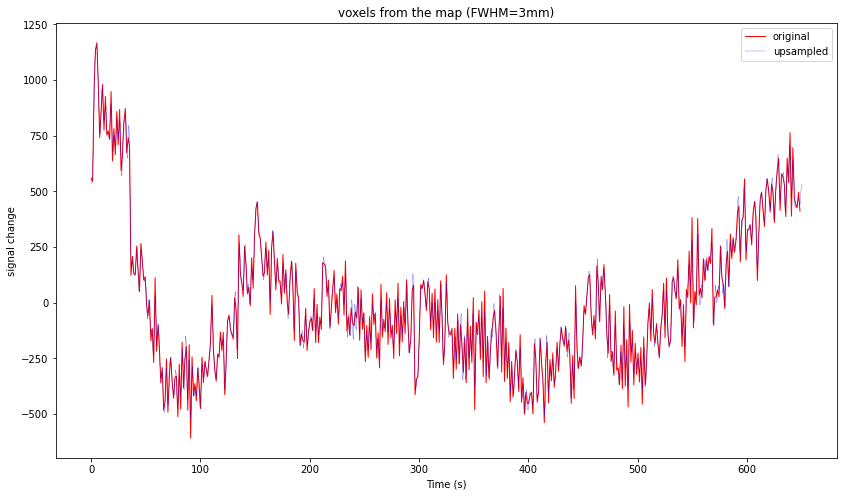

In [14]:
f, ax = plt.subplots(figsize=(14,8))
data = flicker_voxels[:,:2]
data = signal._detrend(data, type="linear")
og_time = data.shape[0]*1.3
res_y, res_t = resample(data[:,1], int(og_time/0.0005), t=time, window=2)
plt.plot(time, data[:,1], "red", alpha=1, lw=1, label="original")
plt.plot(res_t, res_y, "blue", lw=0.25, label="upsampled")
plt.title("voxels from the map (FWHM=3mm)")
plt.ylabel("signal change")
plt.xlabel("Time (s)")
plt.legend();

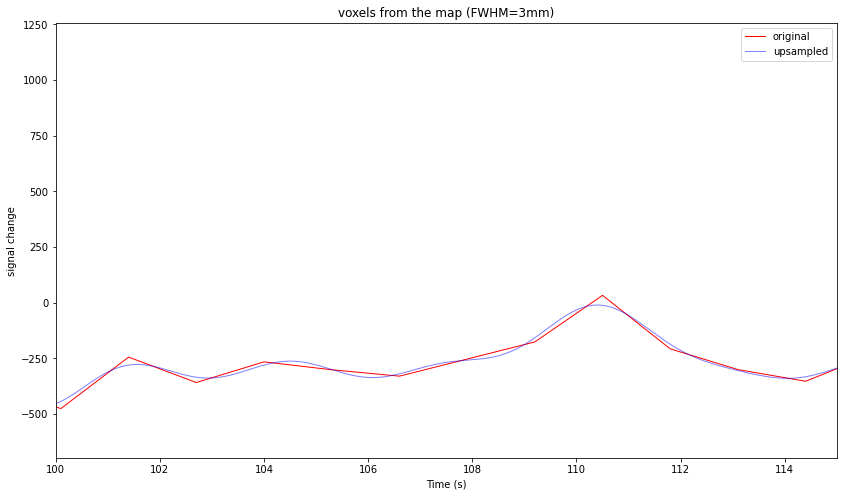

In [15]:
f, ax = plt.subplots(figsize=(14,8))
plt.plot(time, data[:,1], "red", alpha=1, lw=1, label="original")
plt.plot(res_t, res_y, "blue", lw=1, alpha=0.5, label="upsampled")
plt.title("voxels from the map (FWHM=3mm)")
plt.ylabel("signal change")
plt.xlabel("Time (s)")
plt.xlim([100, 115])
plt.legend();

### FFT

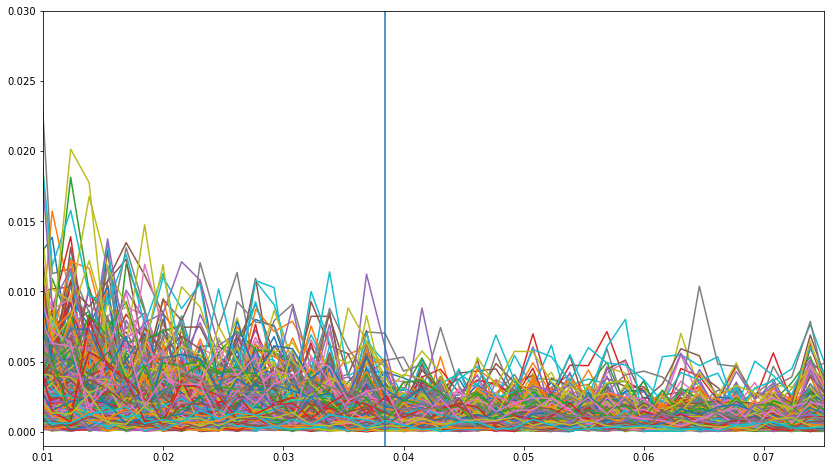

In [26]:
f, ax = plt.subplots(figsize=(14,8))
data = flicker_voxels
res_x = resample(data, int(og_time/0.0005), axis=0)

fft_Y = fft(res_x, axis=0)
fft_FREQ = fftfreq(fft_Y.shape[0], 0.0005)
fft_Y = fft_Y[:200]
fft_FREQ = fft_FREQ[:200]

plt.plot(fft_FREQ, np.abs(fft_Y)/1e10)
plt.xlim(0.01,0.075)
plt.ylim((-.001, 0.03))
plt.axvline(0.0385);

In [27]:
below = np.where((fft_FREQ > 0.01) & (fft_FREQ < 0.0355))[0]
above = np.where((fft_FREQ > 0.040) & (fft_FREQ < 0.067))[0]
target_freq = np.where((fft_FREQ > 0.0355) & (fft_FREQ < 0.040))[0]
around = np.concatenate([above, below])
around.sort()

sel = np.take(fft_Y, around, axis=0)
tar = np.take(fft_Y, target_freq, axis=0)

zsc = [np.apply_along_axis(lambda x: (x - sel.mean())/sel.std(), 0, tar[:,i]) for i in range(tar.shape[1])]
zsc_best = np.array([max(i.min(), i.max(), key=abs) for i in zsc])
print(np.real(zsc_best))

[-2.50578612e-01  4.89739418e-01 -2.73691595e-01 -2.28630379e-02
 -1.89027518e-01  1.02439575e-01  5.06304801e-01  5.17229915e-01
  4.53688174e-01 -2.95213848e-01  5.61643168e-02  1.21764287e-01
 -2.65624464e-01 -1.88554689e-01  1.66557789e-01  1.48669422e+00
  4.15551722e-01  9.47673433e-03  1.69803008e-01  1.51185483e-01
  1.18301131e-01  6.46389127e-01  1.30298668e-05  9.74452198e-01
  6.77641332e-01  1.14758158e+00  2.50576758e+00  1.16978276e+00
  8.94220918e-02  3.71844471e-01  4.48072731e-01 -3.24114949e-01
 -4.21723090e-02  2.84325629e-01  2.27204859e-01  3.67854625e-01
  7.23204017e-01  6.20062828e-01  4.24407631e-01  1.32404059e-01
 -2.35229060e-02 -6.08394086e-01  1.34026253e+00  7.04639018e-01
  2.12793738e-01 -2.97801167e-01  1.04551435e+00  1.07189739e+00
 -3.55240703e-02 -5.15632093e-01  1.62411943e-01  1.20407081e+00
 -2.26725102e-03 -4.71997589e-01 -2.85938412e-01 -7.72142336e-02
  2.39045501e+00 -1.84519768e+00 -1.08544871e-01  2.02178717e-01
  7.33149275e-02  4.66475

In [29]:
zsc_best.shape

(500,)

In [18]:
occipital_lobe_results = np.load("zero_pad.npy")
occipital_lobe_results = occipital_lobe_results - 9
mask_ = masking.unmask(occipital_lobe_results, roi)


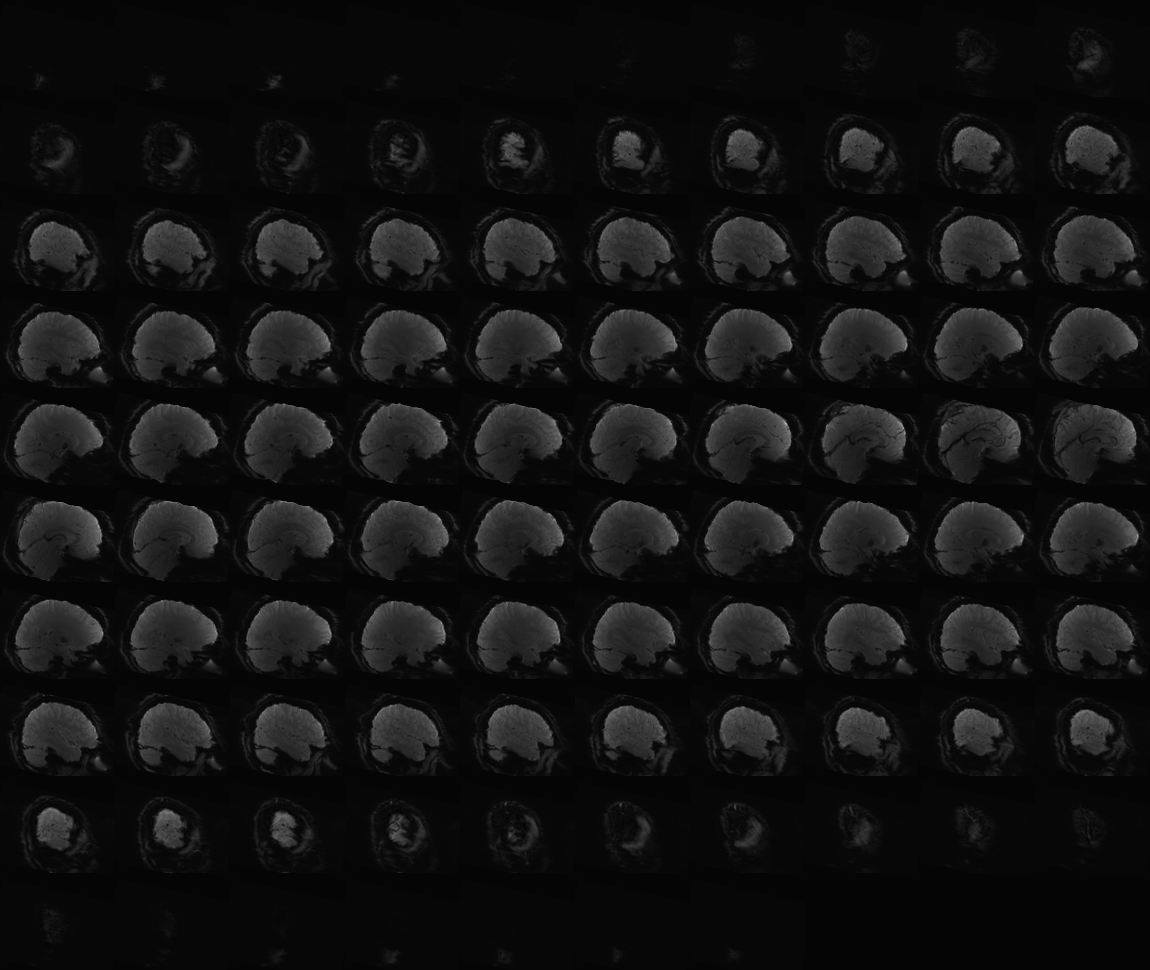
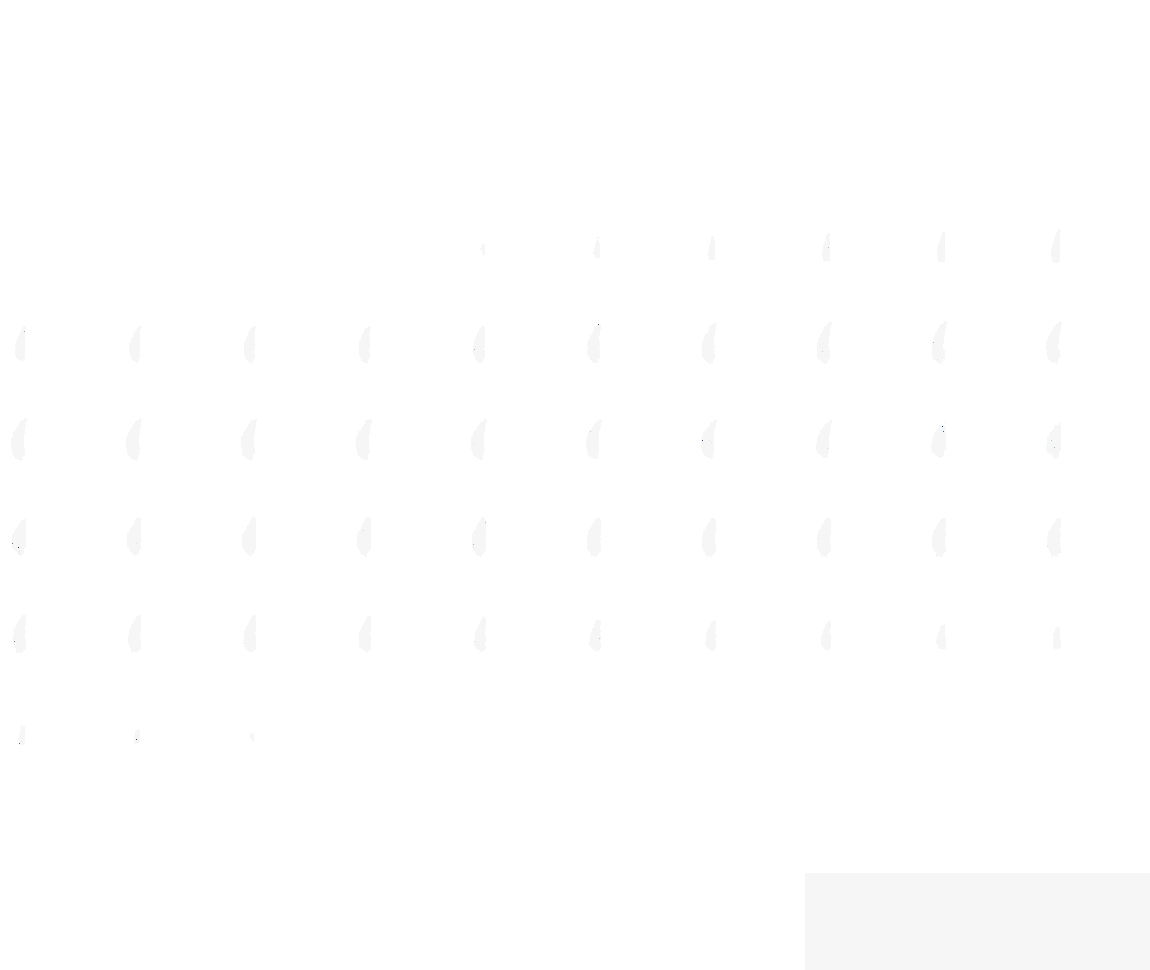

In [19]:
plotting.view_img(mask_, bg_img=mean_flicker, cmap="RdBu_r", threshold=0.0, black_bg=True, colorbar=True)

### ZERO PADDING

In [6]:
flicker_masked = masking.apply_mask(flicker, roi, smoothing_fwhm=3)

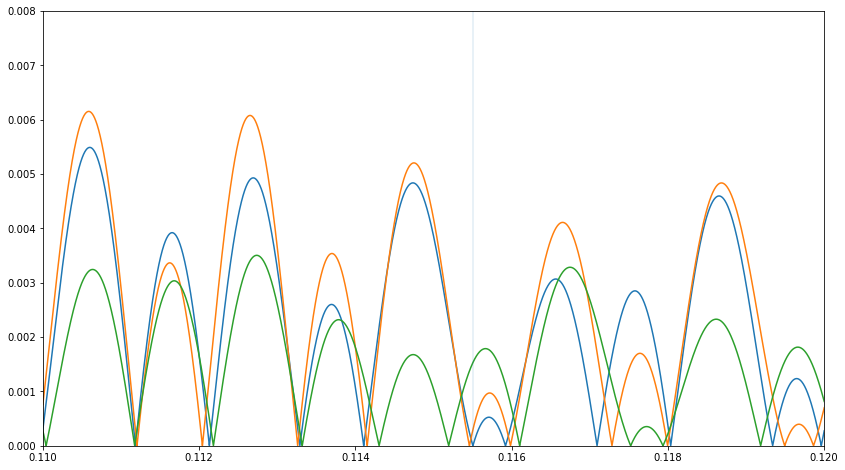

In [146]:
results = []
f, ax = plt.subplots(figsize=(14,8))
for voxel_ix in range(3):
    voxel_tc = flicker_masked[:,voxel_ix]
    padded = np.zeros(int(flicker_masked.shape[0]/0.0005))
    padded[:flicker_masked.shape[0]] = voxel_tc
    fft_Y = fft(voxel_tc, int(flicker_masked.shape[0]/0.0005))
    fft_FREQ = fftfreq(fft_Y.shape[0])
    fft_Y = np.fft.fftshift(fft_Y)
    fft_FREQ = np.fft.fftshift(fft_FREQ)
    fft_Y = np.absolute(np.real(fft_Y))
    harmonics = np.array([np.where(fft_FREQ >= i)[0][0] for i in np.arange(1,10) * 0.0385])
    peak = [np.array((i, i+2)) for i in harmonics]
    around = [np.array((i[0]-20, i[1]+20))  for i in peak]
    for (p_s, p_e),(a_s, a_e) in list(zip(peak, around)):
        o = np.max(fft_Y[p_s:p_e])/ np.mean(np.hstack([fft_Y[a_s:p_s], fft_Y[p_e:a_e]]))

In [80]:
[np.where(fft_FREQ == i)[0] for i in np.arange(0, 0.5, 0.0385)[1:]]

[array([538500]),
 array([577000]),
 array([615500]),
 array([654000]),
 array([692500]),
 array([731000]),
 array([], dtype=int64),
 array([808000]),
 array([846500]),
 array([885000]),
 array([923500]),
 array([962000])]

array([538500, 577000, 615500, 654000, 692500, 731000, 769501, 808000,
       846500])

In [159]:
harmonics = np.array([np.where(fft_FREQ >= i)[0][0] for i in np.arange(1,10) * 0.0385])
peak = [np.array((i, i+2)) for i in harmonics]
around = [ np.array((i[0]-20, i[1]+20))  for i in peak]

In [170]:
fft_Y = np.real(fft_Y)
for (p_s, p_e),(a_s, a_e) in list(zip(peak, around)):
    o = np.max(fft_Y[p_s:p_e])/ np.mean(np.hstack([fft_Y[a_s:p_s], fft_Y[p_e:a_e]]))

538500 538480 538502 538522
1.000726
577000 576980 577002 577022
1.0028611
615500 615480 615502 615522
0.9998133
654000 653980 654002 654022
1.0027449
692500 692480 692502 692522
1.0007105
731000 730980 731002 731022
1.0018907
769501 769481 769503 769523
1.0007744
808000 807980 808002 808022
0.99985105
846500 846480 846502 846522
1.0013016


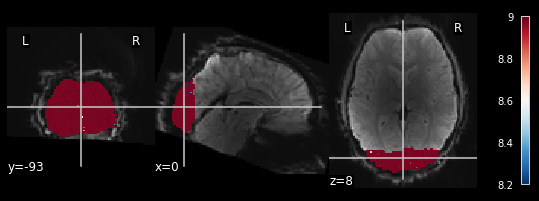

In [6]:
occipital_lobe_results = np.load("zero_pad.npy")
mask_ = masking.unmask(occipital_lobe_results, roi)
plotting.plot_img(mask_, bg_img=mean_flicker, cmap="RdBu_r", threshold=0.0001, black_bg=True, colorbar=True)

In [30]:
flicker_voxels.shape

(500, 500)